In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ft2font
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import itertools
from itertools import zip_longest
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse import dok_matrix
from scipy.sparse import block_diag
from scipy.sparse.linalg import eigsh
import scipy.linalg as la
import os
import Hamiltonian_definition as HD

In [2]:
# save_path = "/home/costanza/UNIVERSITÀ/secondo semestre/MOLTI CORPI/dati/"
save_path = r"C:/Users/Costa/UNIVERSITÀ/secondo semestre/MOLTI CORPI/dati/"


## Lattice definition

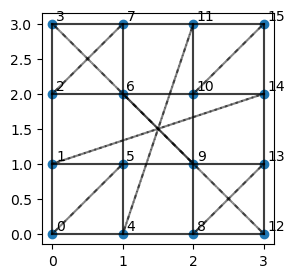

0 --> Nearest neighbors: [4, 3]  -- Next neighbor: [5]
1 --> Nearest neighbors: [5, 0]  -- Next neighbor: [14]
2 --> Nearest neighbors: [6, 1]  -- Next neighbor: [7]
3 --> Nearest neighbors: [7, 2]  -- Next neighbor: [12]
4 --> Nearest neighbors: [8, 7]  -- Next neighbor: [11]
5 --> Nearest neighbors: [9, 4]  -- Next neighbor: [0]
6 --> Nearest neighbors: [10, 5]  -- Next neighbor: [9]
7 --> Nearest neighbors: [11, 6]  -- Next neighbor: [2]
8 --> Nearest neighbors: [12, 11]  -- Next neighbor: [13]
9 --> Nearest neighbors: [13, 8]  -- Next neighbor: [6]
10 --> Nearest neighbors: [14, 9]  -- Next neighbor: [15]
11 --> Nearest neighbors: [15, 10]  -- Next neighbor: [4]
12 --> Nearest neighbors: [0, 15]  -- Next neighbor: [3]
13 --> Nearest neighbors: [1, 12]  -- Next neighbor: [8]
14 --> Nearest neighbors: [2, 13]  -- Next neighbor: [1]
15 --> Nearest neighbors: [3, 14]  -- Next neighbor: [10]


In [3]:
Lx, Ly = 4,4 # lattice dim
L=Lx*Ly
dim=2**(Lx*Ly)

coor = HD.generate_lattice(Lx,Ly)
neighbors_indices = HD.index_nn(coor,Lx,Ly)
diag_indices = HD.index_nnn(coor,Lx,Ly)

HD.plot_lattice(coor,neighbors_indices,diag_indices)

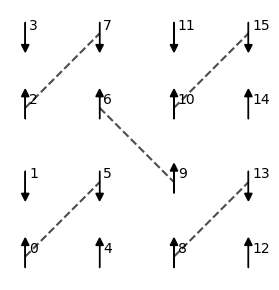

In [4]:
spins = [+1, -1, +1, -1, +1, -1, +1, -1, +1, +1, +1, -1, +1, -1, +1, -1]
HD.plot_dimer(coor,neighbors_indices,diag_indices,spins)

## Chancing J1 J2

In [ ]:

"""
N=9
HN = HD.build_HN(Lx,Ly,N,J1,J2,neighbors_indices,diag_indices)
HN = HN.toarray()

eigvals, eigvecs = la.eigh(HN)
print(eigvals[0])"
"""


### Diagonalization

In [5]:
#angles = [(2*i-1)*np.pi/16 for i in range(6)]
#theta = angles[1:-1]
print(theta)



[0.39269908169872414]
9
10
11
12
13
14
15
16


In [35]:
%%time
J1 = [0.01]
J2 = [1.0]
#for i in range(len(theta)):
for i in range(len(J1)):
    print("-------------------------------")
    # print(i, f"theta={theta[i]}")
    # J1=np.sin(theta[i])
    # J2=np.cos(theta[i])
    print(i)
    J1=J1[i]
    J2=J2[i]
    folder_name = f"J1={round(J1,2)}_J2={round(J2,2)}/"
    full_path = save_path + folder_name
    os.makedirs(full_path, exist_ok=True)

    HN = []
    for N in range(Lx*Ly+1):
        print(f'N={N}')
        HN.append(HD.build_HN(Lx,Ly,N,J1,J2,neighbors_indices,diag_indices))
        print(HN[N].shape)

        HN_dict = {}
        HN_dict[f'HN_{N}'] = HN[N].toarray()

        eigvals, eigvecs = la.eigh(HN_dict[f'HN_{N}'])
        print(f"finito di diagonalizzare HN_{N} alle", datetime.now())
        print("")
        
        folder_eig = f"eigvals block N={N}/"
        path = full_path + folder_eig
        os.makedirs(path, exist_ok=True)
        np.save(path+f"eigvals_N={N}", eigvals)
        np.save(path+f"eigvecs_N={N}", eigvecs)

-------------------------------
0
N=0
(1, 1)
finito di diagonalizzare HN_0 alle 2025-05-19 14:37:37.606511

N=1
(16, 16)
finito di diagonalizzare HN_1 alle 2025-05-19 14:37:37.651517

N=2
(120, 120)
finito di diagonalizzare HN_2 alle 2025-05-19 14:37:37.730041

N=3
(560, 560)
finito di diagonalizzare HN_3 alle 2025-05-19 14:37:38.152628

N=4
(1820, 1820)
finito di diagonalizzare HN_4 alle 2025-05-19 14:37:41.230264

N=5
(4368, 4368)
finito di diagonalizzare HN_5 alle 2025-05-19 14:38:07.096245

N=6
(8008, 8008)
finito di diagonalizzare HN_6 alle 2025-05-19 14:42:51.534092

N=7
(11440, 11440)
finito di diagonalizzare HN_7 alle 2025-05-19 14:48:13.648201

N=8
(12870, 12870)
finito di diagonalizzare HN_8 alle 2025-05-19 15:08:15.610471

N=9
(11440, 11440)
finito di diagonalizzare HN_9 alle 2025-05-19 15:21:41.772747

N=10
(8008, 8008)
finito di diagonalizzare HN_10 alle 2025-05-19 15:25:30.736986

N=11
(4368, 4368)
finito di diagonalizzare HN_11 alle 2025-05-19 15:25:54.410863

N=12
(1820

## Reading data

### Eigen values

#### J1=0, J2=1

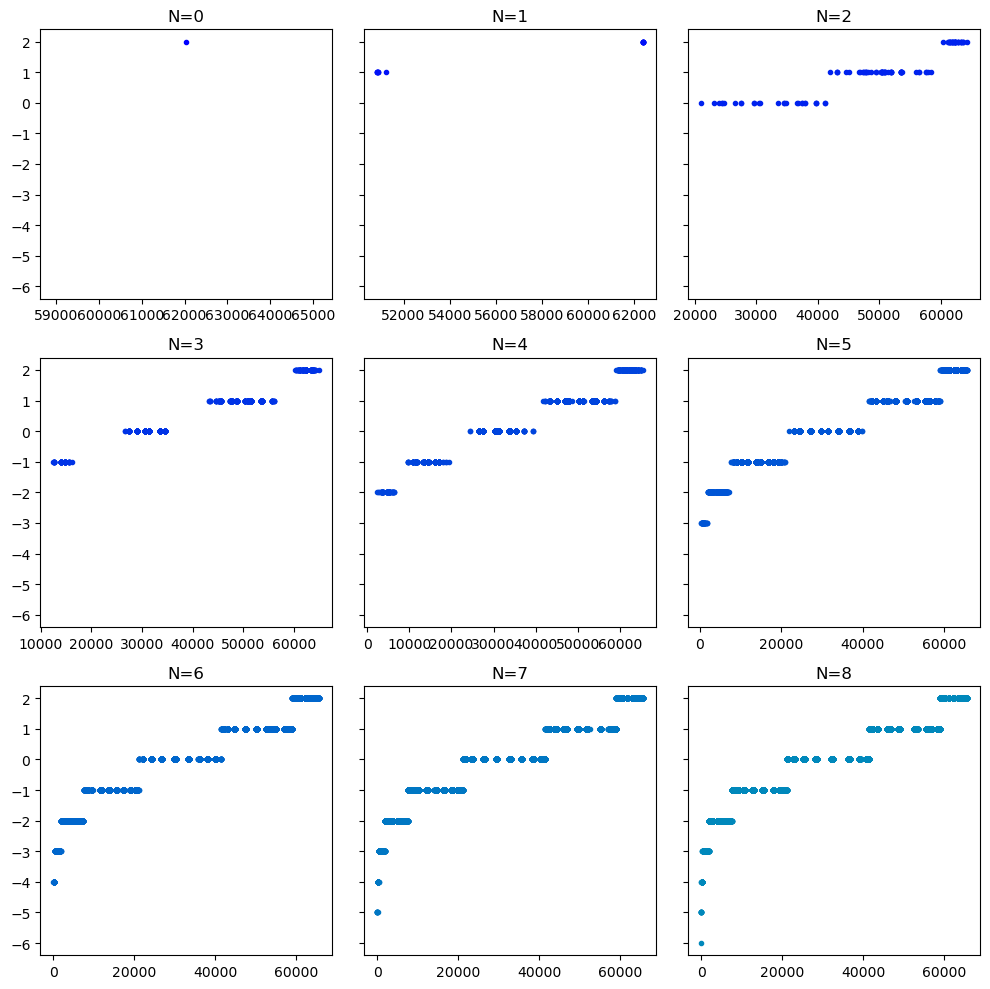

In [18]:

fig, axes = plt.subplots(3,3, figsize=(10, 10), sharey=True)

for i, ax in enumerate(axes.flatten()):
    mask = all_labels_sorted == i
    ax.plot(np.where(mask)[0], all_eigvals_sorted[mask], '.', color=colors[i])
    ax.set_title(f"N={i}")
plt.tight_layout()
plt.show()

C:\Users\Costa\AppData\Local\Temp\ipykernel_308\2177556124.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap("winter")


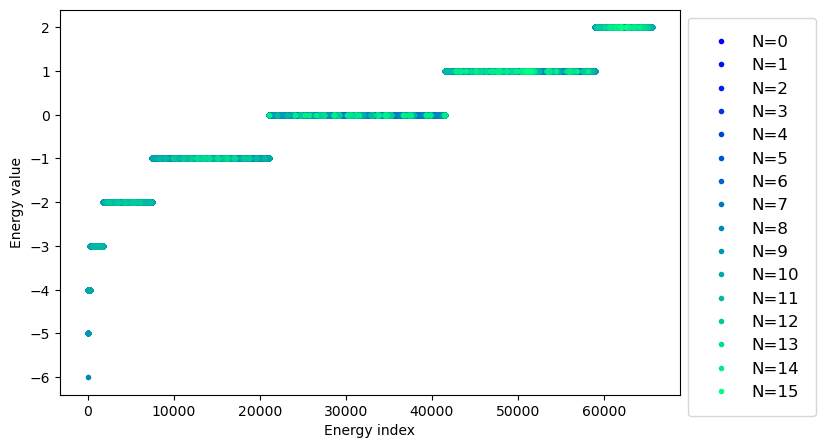

In [16]:
plt.figure(figsize=(8,5))
colormap = get_cmap("winter")
colors = colormap(np.linspace(0, 1, 16))

all_eigvals = []
all_labels = []
for i in range(16):
    a=np.load(save_path+"J1=0.0_J2=1.0/"+f"eigvals block N={i}/"+f"eigvals_N={i}.npy")
    all_eigvals.extend(a)
    all_labels.extend([i]*len(a)) 

all_eigvals = np.array(all_eigvals)
all_labels = np.array(all_labels)
sorted_indices = np.argsort(all_eigvals)
all_eigvals_sorted = all_eigvals[sorted_indices]
all_labels_sorted = all_labels[sorted_indices]

for i in range(16):
    mask = all_labels_sorted == i
    plt.plot(np.where(mask)[0], all_eigvals_sorted[mask], '.', color=colors[i], label=f"N={i}")

# plt.xlim(-5,50)
# plt.ylim(-5.05,-4.95)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderpad=1, fontsize=12)
plt.ylabel("Energy value")
plt.xlabel("Energy index")
# plt.savefig(save_path+"dimer phase enrgies")
plt.show()

eigvals_0_1 = all_eigvals_sorted
labels_0_1 = all_labels_sorted

In [6]:
E0_0 = all_eigvals_sorted[0]
index_e0_0 = 0
index = all_labels_sorted[0]
print(E0_0, index_e0_0, index)

E1_0 = all_eigvals_sorted[1]
index_e1_0 = 1
index = all_labels_sorted[1]
print(E1_0, index_e1_0, index)

-5.9999999999999885 0 8
-5.0000000000000115 1 9


#### J1=1, J2=0

C:\Users\Costa\AppData\Local\Temp\ipykernel_14292\393685505.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap("winter")


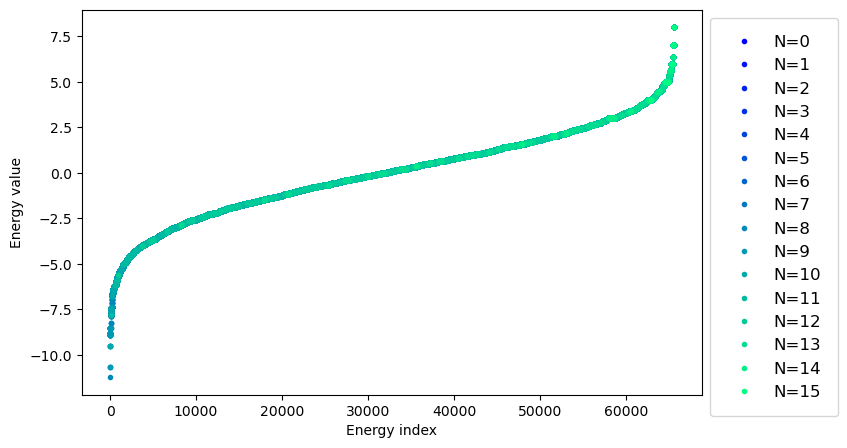

-11.228483208428814


In [16]:
plt.figure(figsize=(8,5))
colormap = get_cmap("winter")
colors = colormap(np.linspace(0, 1, 16))

all_eigvals = []
all_labels = []
for i in range(16):
    a=np.load(save_path+"J1=1.0_J2=0.0/"+f"eigvals block N={i}/"+f"eigvals_N={i}.npy")
    all_eigvals.extend(a)
    all_labels.extend([i]*len(a)) 

all_eigvals = np.array(all_eigvals)
all_labels = np.array(all_labels)
sorted_indices = np.argsort(all_eigvals)
all_eigvals_sorted = all_eigvals[sorted_indices]
all_labels_sorted = all_labels[sorted_indices]

for i in range(16):
    mask = all_labels_sorted == i
    plt.plot(np.where(mask)[0], all_eigvals_sorted[mask], '.', color=colors[i], label=f"N={i}")

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderpad=1, fontsize=12)
plt.ylabel("Energy value")
plt.xlabel("Energy index")
plt.show()
print(all_eigvals_sorted[0])

eigvals_1_0 = all_eigvals_sorted
labels_1_0 = all_labels_sorted



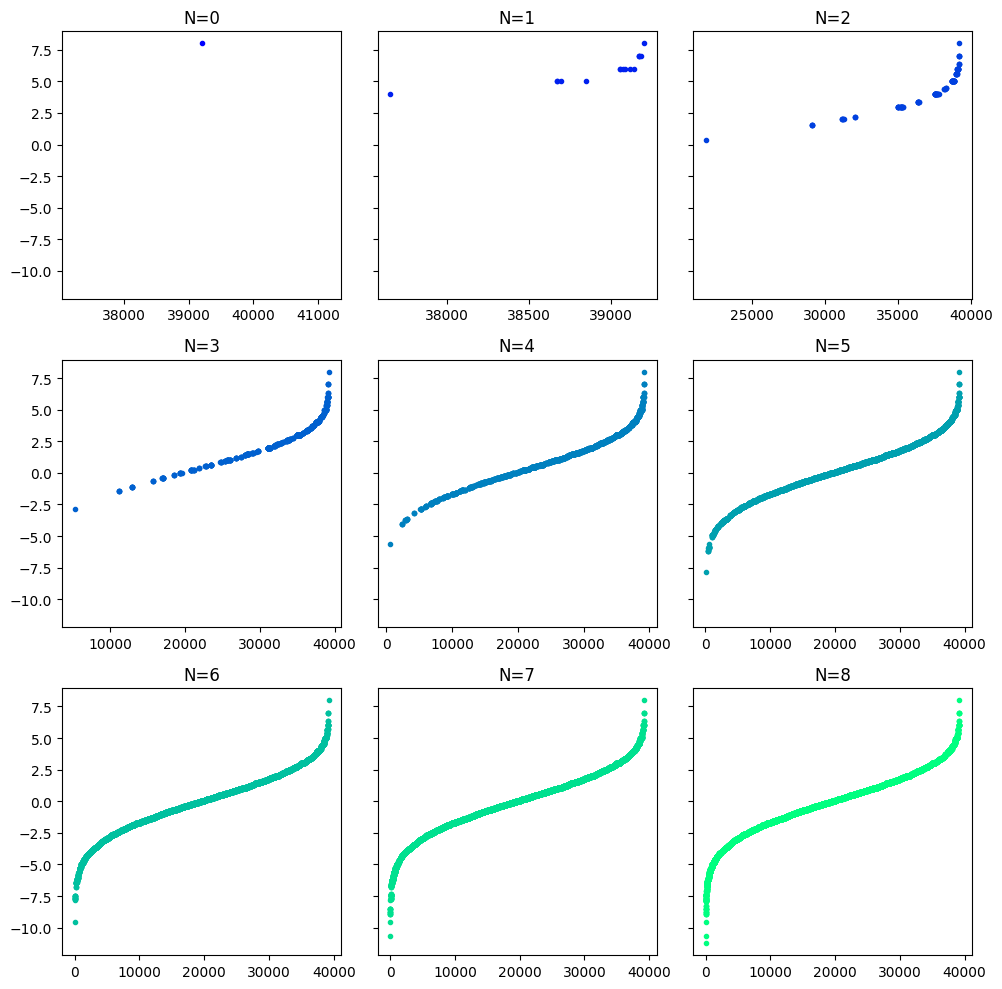

In [7]:
fig, axes = plt.subplots(3,3, figsize=(10, 10), sharey=True)

for i, ax in enumerate(axes.flatten()):
    mask = all_labels_sorted == i
    ax.plot(np.where(mask)[0], all_eigvals_sorted[mask], '.', color=colors[i])
    ax.set_title(f"N={i}")
plt.tight_layout()
plt.show()

#### Other values of J1 and J2

C:\Users\Costa\AppData\Local\Temp\ipykernel_308\3698151362.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap("winter")
C:\Users\Costa\AppData\Local\Temp\ipykernel_308\3698151362.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


J1=0.0_J2=1.0/, N=7, energia minima di questo sottospazio = -5.000000000000006
J1=0.0_J2=1.0/, N=8, energia minima di questo sottospazio = -5.9999999999999885
J1=0.2_J2=0.98/, N=7, energia minima di questo sottospazio = -4.9467401058262945
J1=0.2_J2=0.98/, N=8, energia minima di questo sottospazio = -5.8847116824193835
J1=0.38_J2=0.92/, N=7, energia minima di questo sottospazio = -4.813386338298176
J1=0.38_J2=0.92/, N=8, energia minima di questo sottospazio = -5.543277195067721
J1=0.56_J2=0.83/, N=7, energia minima di questo sottospazio = -4.7155244440967685
J1=0.56_J2=0.83/, N=8, energia minima di questo sottospazio = -5.003067352111836
J1=0.71_J2=0.71/, N=7, energia minima di questo sottospazio = -6.359037719480635
J1=0.71_J2=0.71/, N=8, energia minima di questo sottospazio = -6.80538265006799
J1=0.83_J2=0.56/, N=7, energia minima di questo sottospazio = -7.917143056860151
J1=0.83_J2=0.56/, N=8, energia minima di questo sottospazio = -8.419872389258353
J1=0.92_J2=0.38/, N=7, energia 

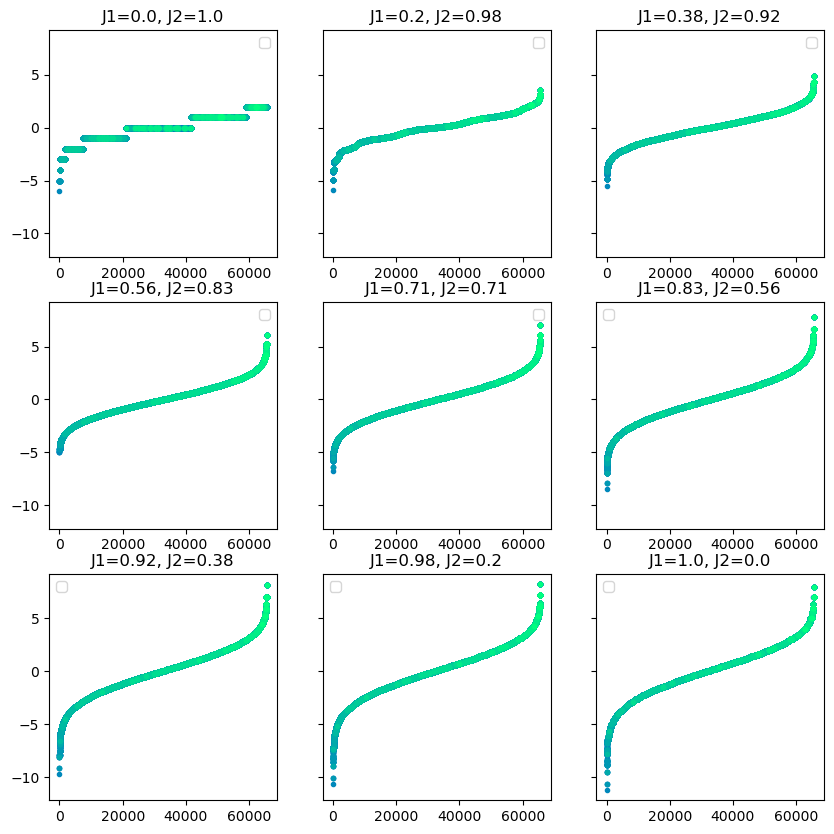

In [22]:
folder = ["J1=0.0_J2=1.0/", "J1=0.2_J2=0.98/","J1=0.38_J2=0.92/",
          "J1=0.56_J2=0.83/", "J1=0.71_J2=0.71/", "J1=0.83_J2=0.56/", 
          "J1=0.92_J2=0.38/", "J1=0.98_J2=0.2/", "J1=1.0_J2=0.0/"]
all_theta = [i*np.pi/16 for i in range(16)]

eigvals_dict = {}
labels_dict = {}

fig, axes = plt.subplots(3,3, figsize=(10, 10), sharey=True)
for F, ax in enumerate(axes.flatten()):
    colormap = get_cmap("winter")
    colors = colormap(np.linspace(0, 1, 16))

    all_eigvals = []
    all_labels = []
    for i in range(16):
        eigvals = np.load(save_path+folder[F]+f"eigvals block N={i}/"+f"eigvals_N={i}.npy")
        if i==8 or i==7:
            print(f"{folder[F]}, N={i}, energia minima di questo sottospazio = {np.min(eigvals)}")
        all_eigvals.extend(eigvals)
        all_labels.extend([i]*len(eigvals)) 

    all_eigvals = np.array(all_eigvals)
    all_labels = np.array(all_labels)

    sorted_indices = np.argsort(all_eigvals)
    all_eigvals_sorted = all_eigvals[sorted_indices]
    all_labels_sorted = all_labels[sorted_indices]

    for i in range(16):
        mask = all_labels_sorted == i
        ax.plot(np.where(mask)[0], all_eigvals_sorted[mask], '.', color=colors[i])#, label=f"N={i}")
    J1 = np.sin(all_theta[F])
    J2 = np.cos(all_theta[F])
    ax.set_title(f'J1={round(J1,2)}, J2={round(J2,2)}')
    ax.legend()

    eigvals_dict[f'all_theta_{F}'] = all_eigvals_sorted
    labels_dict[f'all_theta_{F}'] = all_labels_sorted

plt.show()

J1=1.0_J2=0.0/


/tmp/ipykernel_14031/2989311106.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("winter")


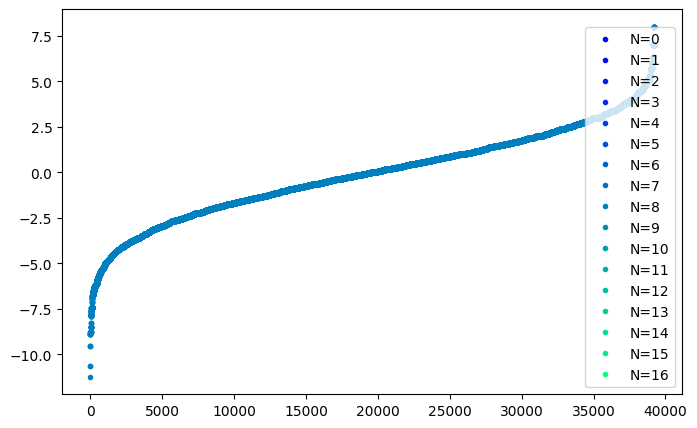

In [ ]:
#plotting of single spectrum
F=8
print(folder[F])
colormap = get_cmap("winter")
colors = colormap(np.linspace(0, 1, 17))psi1 = eigvecs[:,0]
psi2 = eigvecs[:,0]

SiSj_nn_exval, SiSj_nnn_exval = HD.spin_corr(Lx,Ly,psi1,psi2,N,neighbors_indices,diag_indices)

print("nearest neighbor correlation", SiSj_nn_exval)
print("next neighbor correlation", SiSj_nnn_exval)
plt.figure(figsize=(8,5))psi1 = eigvecs[:,0]
psi2 = eigvecs[:,0]

SiSj_nn_exval, SiSj_nnn_exval = HD.spin_corr(Lx,Ly,psi1,psi2,N,neighbors_indices,diag_indices)

print("nearest neighbor correlation", SiSj_nn_exval)
print("next neighbor correlation", SiSj_nnn_exval)
for i in range(17):
    mask = labels_dict[f'all_theta_{F}'] == i
    plt.plot(np.where(mask)[0],eigvals_dict[f'all_theta_{F}'][mask], '.', color=colors[i], label=f"N={i}")

plt.legend()

J1=0.56_J2=0.83/


/tmp/ipykernel_14031/2351494737.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("winter")


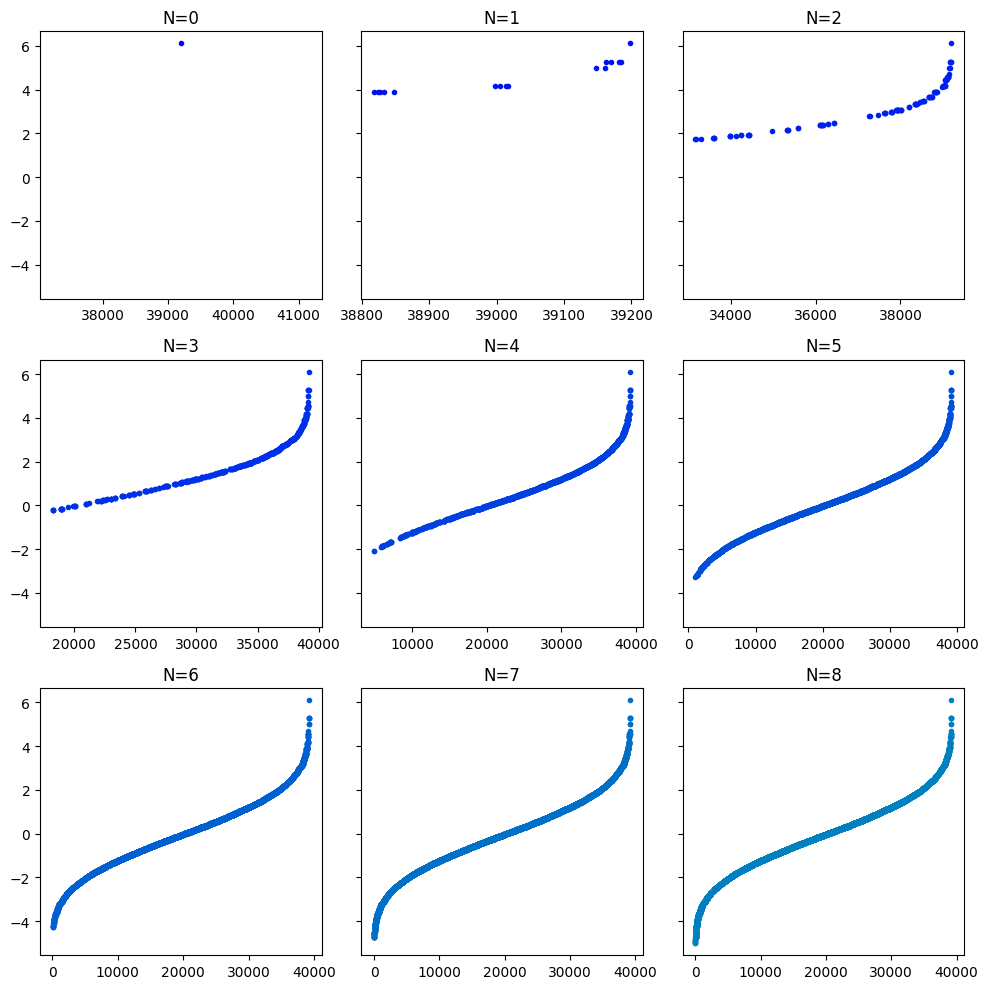

In [11]:
fig, axes = plt.subplots(3,3, figsize=(10, 10), sharey=True)
F=3
print(folder[F])
colormap = get_cmap("winter")
colors = colormap(np.linspace(0, 1, 17))
for i, ax in enumerate(axes.flatten()):
    mask = labels_dict[f'all_theta_{F}'] == i
    ax.plot(np.where(mask)[0], eigvals_dict[f'all_theta_{F}'][mask], '.', color=colors[i])
    ax.set_title(f"N={i}")
plt.tight_layout()
plt.show()

### J1=1, J2=0.01

/tmp/ipykernel_21767/695694716.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("winter")


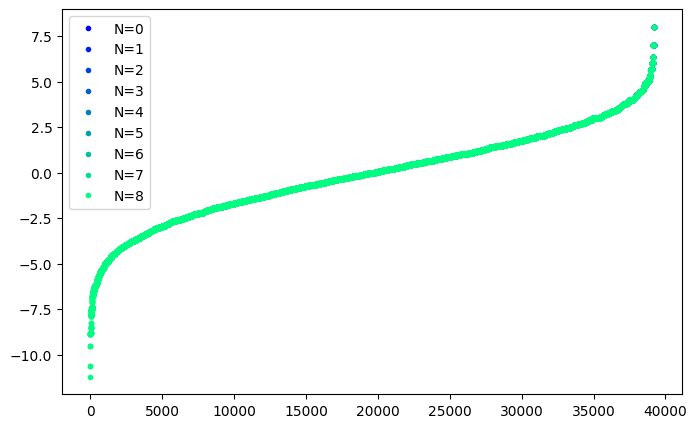

-11.211389276164043


In [9]:
plt.figure(figsize=(8,5))
colormap = get_cmap("winter")
colors = colormap(np.linspace(0, 1, 9))

all_eigvals = []
all_labels = []
for i in range(9):
    a=np.load(save_path+"J1=1.0_J2=0.01/"+f"eigvals block N={i}/"+f"eigvals_N={i}.npy")
    all_eigvals.extend(a)
    all_labels.extend([i]*len(a)) 

all_eigvals = np.array(all_eigvals)
all_labels = np.array(all_labels)
sorted_indices = np.argsort(all_eigvals)
all_eigvals_sorted = all_eigvals[sorted_indices]
all_labels_sorted = all_labels[sorted_indices]

for i in range(9):
    mask = all_labels_sorted == i
    plt.plot(np.where(mask)[0], all_eigvals_sorted[mask], '.', color=colors[i], label=f"N={i}")

plt.legend()
plt.show()
print(all_eigvals_sorted[0])

eigvals_1_0 = all_eigvals_sorted
labels_1_0 = all_labels_sorted

### J1=0.01_J2=1.0

C:\Users\Costa\AppData\Local\Temp\ipykernel_11104\2100955898.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap("winter")


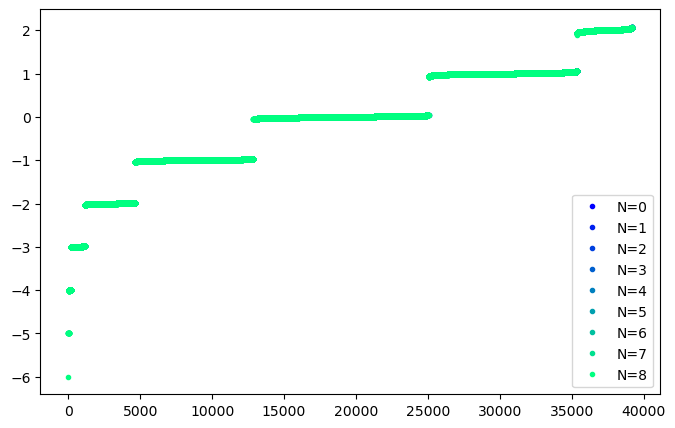

-6.000000000000006


In [ ]:
plt.figure(figsize=(8,5))
colormap = get_cmap("winter")
colors = colormap(np.linspace(0, 1, 9))

all_eigvals = []
all_labels = []
for i in range(9):
    a=np.load(save_path+"J1=0.01_J2=1.0/"+f"eigvals block N={i}/"+f"eigvals_N={i}.npy")
    all_eigvals.extend(a)
    all_labels.extend([i]*len(a)) 

all_eigvals = np.array(all_eigvals)
all_labels = np.array(all_labels)
sorted_indices = np.argsort(all_eigvals)
all_eigvals_sorted = all_eigvals[sorted_indices]
all_labels_sorted = all_labels[sorted_indices]

for i in range(9):
    mask = all_labels_sorted == i
    plt.plot(np.where(mask)[0], all_eigvals_sorted[mask], '.', color=colors[i], label=f"N={i}")

plt.legend()
plt.show()
print(all_eigvals_sorted[0])

E0_0 = all_eigvals_sorted[0]
index_e0_0 = 0
index = all_labels_sorted[0]
print(E0_0, index_e0_0, index)

E1_0 = all_eigvals_sorted[1]
index_e1_0 = 1
index = all_labels_sorted[0]
print(E1_0, index_e1_0, index)


-6.000000000000006 0 8
-5.000100501234373 1 8


## Analysis

### Plotting energies changing J1, J2

C:\Users\Costa\AppData\Local\Temp\ipykernel_308\1326555295.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap("rainbow")


Text(0, 0.5, 'eigvals')

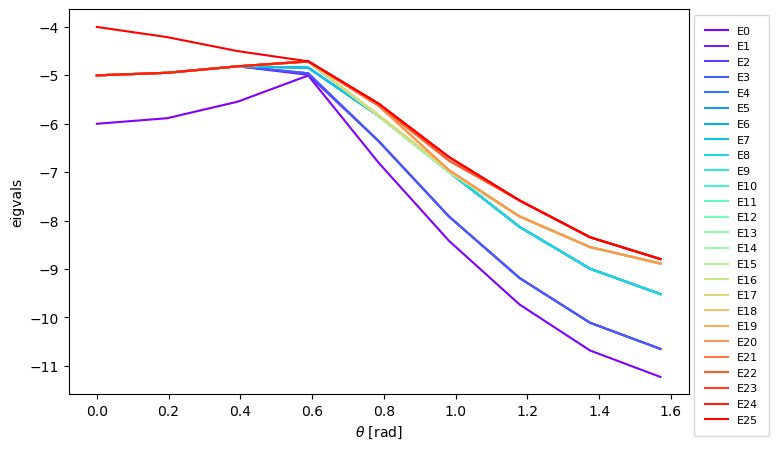

In [83]:
all_theta = [i*np.pi/16 for i in range(9)]
all_theta = np.array(all_theta)
number = 26 #how many eigen values do you want?
J1 = np.sin(all_theta)
J2 = np.cos(all_theta)
plt.figure(figsize=(8,5))
colormap = get_cmap("rainbow")
colors = colormap(np.linspace(0, 1, number))
for j in range(number):
    energy = [eigvals_dict[f'all_theta_{i}'][j] for i in range(len(all_theta))]
    plt.plot(all_theta, energy, label=f'E{j}',color=colors[j])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderpad=1, fontsize=8)

plt.xlabel(r'$\theta$ [rad]')# -- (J1=sin($\theta$))')
plt.ylabel('eigvals')
#plt.xlim(0.4,0.8)
#plt.ylim(-6,-4)

### gap changing J1, J2

0.0 J1=0.0, J2=1.0, J1/J2=0.0
0.2 J1=0.2, J2=0.98, J1/J2=0.19891
0.39 J1=0.38, J2=0.92, J1/J2=0.41421
0.59 J1=0.56, J2=0.83, J1/J2=0.66818
0.79 J1=0.71, J2=0.71, J1/J2=1.0
0.98 J1=0.83, J2=0.56, J1/J2=1.49661
1.18 J1=0.92, J2=0.38, J1/J2=2.41421
1.37 J1=0.98, J2=0.2, J1/J2=5.02734
1.57 J1=1.0, J2=0.0, J1/J2=1.633123935319537e+16


C:\Users\Costa\AppData\Local\Temp\ipykernel_308\2840111217.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


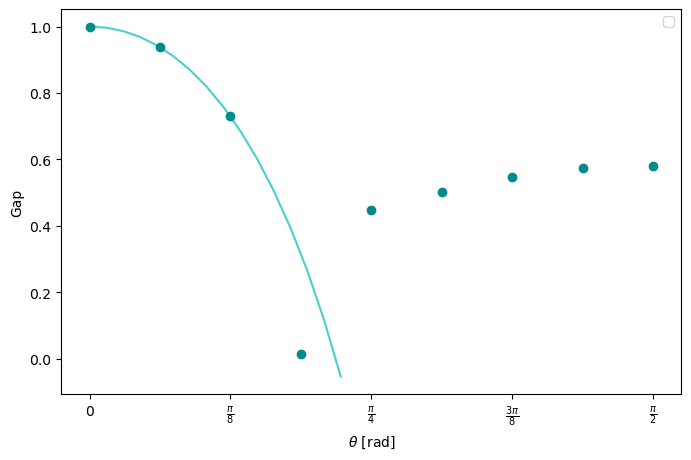

[1.         0.93797158 0.72989086 0.01424968 0.44634493 0.50272933
 0.54701688 0.57307467 0.57859834]
[ -5.          -4.94674011  -4.81338634  -4.98881767  -6.35903772
  -7.91714306  -9.18544797 -10.10902291 -10.64988487]
[ -6.          -5.88471168  -5.5432772   -5.00306735  -6.80538265
  -8.41987239  -9.73246485 -10.68209758 -11.22848321]


In [66]:

plt.figure(figsize=(8,5))
GS = [eigvals_dict[f'all_theta_{i}'][0] for i in range(len(all_theta))]
E1 = [eigvals_dict[f'all_theta_{i}'][1] for i in range(len(all_theta))]
J1 = np.sin(all_theta)
J2 = np.cos(all_theta)

theta = [i * 0.7 / 15 for i in range(16)]
gap = np.cos(theta)*(1-(np.tan(theta))**2-0.5*(np.tan(theta))**3-0.125*(np.tan(theta))**4)
for i in range(len(all_theta)):
    print(round(all_theta[i],2), f'J1={round(J1[i],2)}, J2={round(J2[i],2)}, J1/J2={round(J1[i]/J2[i],5)}')
plt.plot(theta, gap, color="mediumturquoise")
plt.plot(all_theta, np.array(E1)-np.array(GS), "o", color="darkcyan")
plt.xlabel(r'$\theta$ [rad]')#-- (J1=sin($\theta$))')
plt.ylabel('Gap')
plt.legend()
xticks = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]
xtick_labels = [r"$0$", r"$\frac{\pi}{8}$", r"$\frac{\pi}{4}$", r"$\frac{3\pi}{8}$", r"$\frac{\pi}{2}$"]
plt.xticks(xticks, xtick_labels)
plt.show()
print(np.array(E1)-np.array(GS))
print(np.array(E1))
print(np.array(GS))

### dimer state energy

In [24]:
folder = ["J1=0.0_J2=1.0/", "J1=0.2_J2=0.98/","J1=0.38_J2=0.92/",
          "J1=0.56_J2=0.83/", "J1=0.71_J2=0.71/", "J1=0.83_J2=0.56/", 
          "J1=0.92_J2=0.38/", "J1=0.98_J2=0.2/", "J1=1.0_J2=0.0/"]

# dimer phase - ground state
F = 0
N = 8 
print(folder[F])
eigvals = np.load(save_path+folder[F]+f"eigvals block N={N}/"+f"eigvals_N={N}.npy") 
eigvecs = np.load(save_path+folder[F]+f"eigvals block N={N}/"+f"eigvecs_N={N}.npy")
print(eigvecs.shape)

min_index = np.argmin(eigvals)
dimer_state = eigvecs[:, min_index]



J1=0.0_J2=1.0/
(12870, 12870)


In [25]:
energies = []
found_indices = []

dimer_state = dimer_state / np.linalg.norm(dimer_state) # normalization just in case

for i, folder_name in enumerate(folder):
    eigvals_i = np.load(save_path + folder_name + f"eigvals block N={N}/eigvals_N={N}.npy")
    eigvecs_i = np.load(save_path + folder_name + f"eigvals block N={N}/eigvecs_N={N}.npy")

    eigvecs_i = eigvecs_i / np.linalg.norm(eigvecs_i, axis=0)

    # Confronta con dimer_state (uso np.allclose o massimo overlap esatto)
    found = False
    for j in range(eigvecs_i.shape[1]):
        if np.allclose(eigvecs_i[:, j], dimer_state, atol=1e-6) or np.allclose(eigvecs_i[:, j], -dimer_state, atol=1e-6):
            energies.append(eigvals_i[j])
            found_indices.append(j)
            found = True
            break
    if not found:
        energies.append(None)
        found_indices.append(None)
        print(f"Stato non trovato in: {folder_name}")

# Output
for i in range(len(folder)):
    print(f"{folder[i]} → index = {found_indices[i]}, energy = {energies[i]}")


Stato non trovato in: J1=1.0_J2=0.0/
J1=0.0_J2=1.0/ → index = 0, energy = -5.9999999999999885
J1=0.2_J2=0.98/ → index = 0, energy = -5.8847116824193835
J1=0.38_J2=0.92/ → index = 0, energy = -5.543277195067721
J1=0.56_J2=0.83/ → index = 1, energy = -4.988817673815271
J1=0.71_J2=0.71/ → index = 280, energy = -4.242640687119285
J1=0.83_J2=0.56/ → index = 1227, energy = -3.333421398117613
J1=0.92_J2=0.38/ → index = 2882, energy = -2.29610059419054
J1=0.98_J2=0.2/ → index = 5027, energy = -1.1705419320967705
J1=1.0_J2=0.0/ → index = None, energy = None


C:\Users\Costa\AppData\Local\Temp\ipykernel_308\2479604495.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap("rainbow")


Text(0, 0.5, 'eigvals')

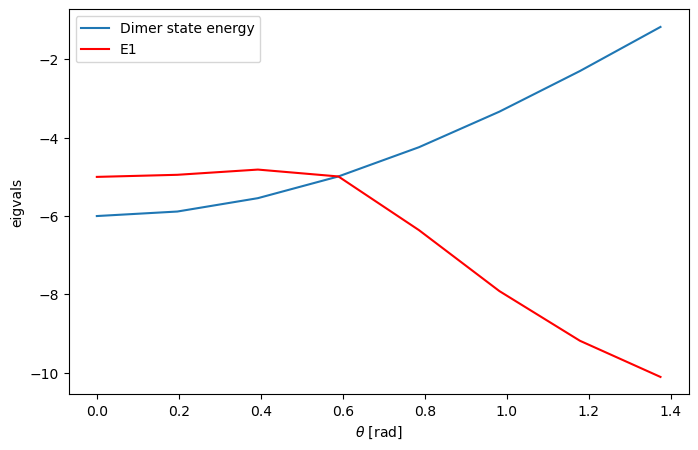

In [72]:
all_theta = [i*np.pi/16 for i in range(9)]
all_theta = np.array(all_theta)
number = 2 #how many eigen values do you want?
J1 = np.sin(all_theta)
J2 = np.cos(all_theta)
plt.figure(figsize=(8,5))
colormap = get_cmap("rainbow")
colors = colormap(np.linspace(0, 1, number))
plt.plot(all_theta[:-1], energies[:-1], label="Dimer state energy")
for j in range(1,number):
    energy = [eigvals_dict[f'all_theta_{i}'][j] for i in range(len(all_theta))]
    plt.plot(all_theta[:-1], energy[:-1], label=f'E{j}',color=colors[j])
    plt.legend()
plt.xlabel(r'$\theta$ [rad]')# -- (J1=sin($\theta$))')
plt.ylabel('eigvals')
#plt.xlim(0.4,0.8)
#plt.ylim(-6,-4)

### Correlation

In [15]:
folder = ["J1=0.0_J2=1.0/", "J1=0.2_J2=0.98/","J1=0.38_J2=0.92/",
          "J1=0.56_J2=0.83/", "J1=0.71_J2=0.71/", "J1=0.83_J2=0.56/", 
          "J1=0.92_J2=0.38/", "J1=0.98_J2=0.2/", "J1=1.0_J2=0.0/", "J1=1.0_J2=0.01/", "J1=0.01_J2=1.0/"]

In [16]:
# loading of the eigen vectors
F = 0 #which folder? ie which values of J1 and J2
N = 8 #which block? ie number of spin up
print(folder[F])
eigvecs = np.load(save_path+folder[F]+f"eigvals block N={N}/"+f"eigvecs_N={N}.npy")
print(eigvecs.shape)

J1=0.0_J2=1.0/
(12870, 12870)


In [17]:
psi1 = eigvecs[:,0]
psi2 = eigvecs[:,0]

SiSj_nn_exval, SiSj_nnn_exval = HD.spin_corr(Lx,Ly,psi1,psi2,N,neighbors_indices,diag_indices)

print("nearest neighbor correlation", SiSj_nn_exval)
print("next neighbor correlation", SiSj_nnn_exval)

nearest neighbor correlation -2.4850514813671553e-31
next neighbor correlation -0.7499999999999991


J1=0.0_J2=1.0/
i=0, j=0, corr=0.7499999999999992
i=0, j=1, corr=5.790696364948877e-17
i=0, j=2, corr=5.750514331805576e-17
i=0, j=3, corr=5.93020181418621e-17
i=1, j=0, corr=5.790696364948877e-17
i=1, j=1, corr=0.7499999999999992
i=1, j=2, corr=-1.6046192152785345e-17
i=1, j=3, corr=-3.816391647148971e-17
i=2, j=0, corr=5.750514331805576e-17
i=2, j=1, corr=-1.6046192152785345e-17
i=2, j=2, corr=0.7499999999999992
i=2, j=3, corr=-1.9949319973733257e-17
i=3, j=0, corr=5.93020181418621e-17
i=3, j=1, corr=-3.816391647148971e-17
i=3, j=2, corr=-1.9949319973733257e-17
i=3, j=3, corr=0.7499999999999992
nearest neighbor correlation -6.97045348245103e-32
next neighbor correlation -0.7499999999999988


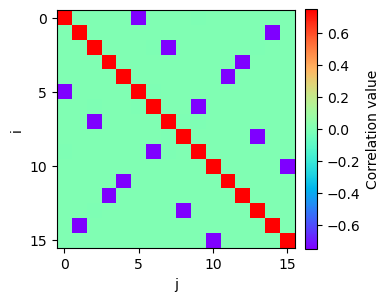

In [18]:
print(folder[F])

GS = eigvecs[:, 0]
L = Lx * Ly
correlations = HD.compute_sisj_correlations(GS, N, L)
for i in range(4):
    for j in range(4):
        print(f'i={i}, j={j}, corr={correlations[i,j]}')

SzSz_nn_exval, SzSz_nnn_exval = HD.sisj_mean(GS,N,L,neighbors_indices,diag_indices)
print("nearest neighbor correlation", SzSz_nn_exval)
print("next neighbor correlation", SzSz_nnn_exval)

# Plot tipo heatmap
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(correlations, cmap='rainbow')

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Correlation value', fontsize=10)

ax.set_xlabel('j')
ax.set_ylabel('i')
ax.set_yticks([0,5,10,15])

plt.tight_layout()
plt.show()





J1=0.0_J2=1.0/
nearest neighbor correlation -6.97045348245103e-32
next neighbor correlation -0.7499999999999988
J1=0.2_J2=0.98/
nearest neighbor correlation -4.968899256519069e-32
next neighbor correlation -0.7499999999999999
J1=0.38_J2=0.92/
nearest neighbor correlation -9.013352139732264e-32
next neighbor correlation -0.75
J1=0.56_J2=0.83/
nearest neighbor correlation -0.32275899963284693
next neighbor correlation 0.11050043220745881
J1=0.71_J2=0.71/
nearest neighbor correlation -0.3458779515410335
next neighbor correlation 0.18047875105604594
J1=0.83_J2=0.56/
nearest neighbor correlation -0.34927691273148237
next neighbor correlation 0.1964981233959616
J1=0.92_J2=0.38/
nearest neighbor correlation -0.35038177217235483
next neighbor correlation 0.2045661717279239
J1=0.98_J2=0.2/
nearest neighbor correlation -0.3507887236228805
next neighbor correlation 0.20980778658124938
J1=1.0_J2=0.0/
nearest neighbor correlation -0.35089010026340034
next neighbor correlation 0.2137652853994237


C:\Users\Costa\AppData\Local\Temp\ipykernel_11104\2352315730.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # lascia spazio per la colorbar


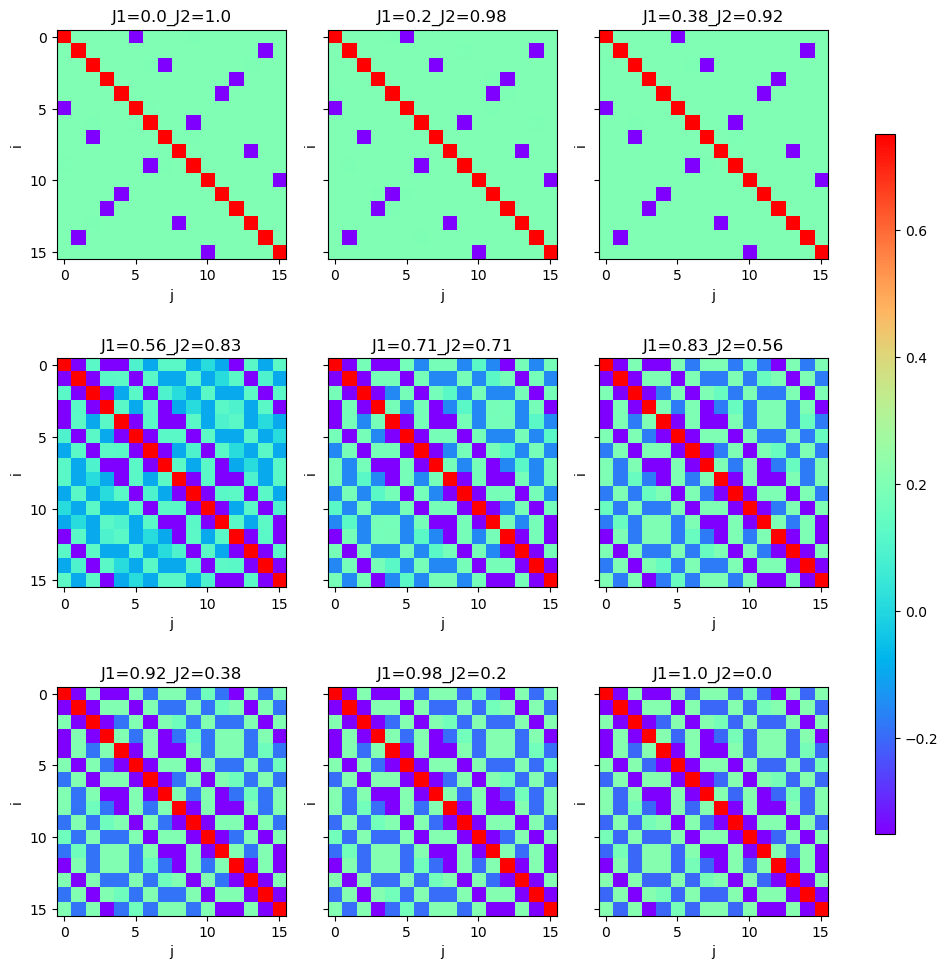

In [7]:
folder = ["J1=0.0_J2=1.0/", "J1=0.2_J2=0.98/","J1=0.38_J2=0.92/",
          "J1=0.56_J2=0.83/", "J1=0.71_J2=0.71/", "J1=0.83_J2=0.56/", 
          "J1=0.92_J2=0.38/", "J1=0.98_J2=0.2/", "J1=1.0_J2=0.0/"]

fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharey=True)

for f, ax in enumerate(axes.flatten()):
    F = f
    N = 8
    print(folder[F])
    eigvecs = np.load(save_path + folder[F] + f"eigvals block N={N}/" + f"eigvecs_N={N}.npy")

    GS = eigvecs[:, 0]
    L = Lx * Ly
    correlations = HD.compute_sisj_correlations(GS, N, L)

    SzSz_nn_exval, SzSz_nnn_exval = HD.sisj_mean(GS, N, L, neighbors_indices, diag_indices)
    print("nearest neighbor correlation", SzSz_nn_exval)
    print("next neighbor correlation", SzSz_nnn_exval)

    # Plot sul subplot specifico
    im = ax.imshow(correlations, cmap='rainbow')
    ax.set_title(folder[F][:-1])  # titolo senza la barra finale
    ax.set_xlabel('j')
    ax.set_ylabel('i')
    ax.set_yticks([0, 5, 10, 15])

# Colorbar globale
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # posizione della colorbar
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # lascia spazio per la colorbar
plt.show()


## Correzioni alla gap nella dimer phase

In [7]:
folder = ["J1=0.0_J2=1.0/", "J1=0.2_J2=0.98/","J1=0.38_J2=0.92/",
          "J1=0.56_J2=0.83/", "J1=0.71_J2=0.71/", "J1=0.83_J2=0.56/", 
          "J1=0.92_J2=0.38/", "J1=0.98_J2=0.2/", "J1=1.0_J2=0.0/", "J1=1.0_J2=0.01/", "J1=0.01_J2=1.0/"]

### ground state

In [ ]:
# loading of the eigen vectors
F = 0 #which folder? ie which values of J1 and J2
N = 8 #which block? ie number of spin up
print(folder[F])
eigvals = np.load(save_path+folder[F]+f"eigvals block N={N}/"+f"eigvals_N={N}.npy")
eigvecs = np.load(save_path + folder[F] + f"eigvals block N={N}/" + f"eigvecs_N={N}.npy")
E0_0 = eigvals[0]
psi0 = eigvecs[:, 0]
print("E0_0 =", E0_0)

F = -1
J1=0.01
J2=1.0
SiSj_nn, _ =  HD.build_SiSj(Lx,Ly,N,neighbors_indices,diag_indices)

# correzione primo ordine
E0_1 = J1 * np.vdot(psi0, SiSj_nn @ psi0)
print("E0 = E0_0 + E0_1 =", E0_0+E0_1)

# secondo ordine
E0_2 = 0
for n in range(1,len(eigvals)):
    psin = eigvecs[:,n]
    En_0 = eigvals[n]
    Vn0 = J1 * np.vdot(psin, SiSj_nn @ psi0)
    E0_2 += (abs(Vn0)**2)/(E0_0-En_0)
print("E0 = E0_0 + E0_1 + E0_2 =", E0_0+E0_1+E0_2)


J1=0.0_J2=1.0/
E0_0 = -5.9999999999999885
E0 = E0_0 + E0_1 = -5.9999999999999885
E0 = E0_0 + E0_1 + E0_2 = -5.9999999999999885


In [19]:
F = -1 #which folder? ie which values of J1 and J2
print(folder[F])
N = 8 #which block? ie number of spin up
eigvals = np.load(save_path+folder[F]+f"eigvals block N={N}/"+f"eigvals_N={N}.npy")
print(eigvals[0])

J1=0.01_J2=1.0/
-6.000000000000006


### primo eccitato

In [16]:
F = 0 #which folder? ie which values of J1 and J2
print(folder[F])
N = 9 #which block? ie number of spin up
eigvals = np.load(save_path+folder[F]+f"eigvals block N={N}/"+f"eigvals_N={N}.npy")
eigvecs = np.load(save_path + folder[F] + f"eigvals block N={N}/" + f"eigvecs_N={N}.npy")
E1_0 = eigvals[0]
psi1 = eigvecs[:,0]
print("E1_0 = ", E1_0)

F = -1
print(folder[F])
SiSj_nn, _ =  HD.build_SiSj(Lx,Ly,N,neighbors_indices,diag_indices)
# correzione primo ordine
E1_1 = J1 * np.vdot(psi1, SiSj_nn @ psi1)
print("E1 = E1_0 + E1_1 =", E1_0+E1_1)

# secondo ordine
epsilon = 1e-6
E1_2 = 0.0
for n in range(1, len(eigvals)):
    deltaE = E1_0 - eigvals[n]
    if abs(deltaE) < epsilon:
        print(f"Ignorato stato quasi-degenere n = {n}")
        continue
    psin = eigvecs[:, n]
    Vn1 = J1 * np.vdot(psin,SiSj_nn @ psi1)
    E1_2 += (abs(Vn1)**2) / deltaE
print("E1 = E1_0 + E1_1 + E1_2 =", E1_0+E1_1+E1_2)



J1=0.0_J2=1.0/
E1_0 =  -5.0000000000000115
J1=0.01_J2=1.0/
E1 = E1_0 + E1_1 = -5.0000000000000115
Ignorato stato quasi-degenere n = 1
Ignorato stato quasi-degenere n = 2
Ignorato stato quasi-degenere n = 3
Ignorato stato quasi-degenere n = 4
Ignorato stato quasi-degenere n = 5
Ignorato stato quasi-degenere n = 6
Ignorato stato quasi-degenere n = 7
E1 = E1_0 + E1_1 + E1_2 = -5.000024180584268


In [18]:
F = -1 #which folder? ie which values of J1 and J2
print(folder[F])
N = 9 #which block? ie number of spin up
eigvals = np.load(save_path+folder[F]+f"eigvals block N={N}/"+f"eigvals_N={N}.npy")
print(eigvals[0])

J1=0.01_J2=1.0/
-5.0001005012343684


In [21]:
gap =  E1_0+E1_1+E1_2 - (E0_0+E0_1+E0_2)
print(gap)

gap_non_pert = E1_0 -E0_0
print(gap_non_pert)

0.9999758194157202
0.9999999999999769


In [22]:
F = -1 #which folder? ie which values of J1 and J2
print(folder[F])
N = 9 #which block? ie number of spin up
eigvals = np.load(save_path+folder[F]+f"eigvals block N={N}/"+f"eigvals_N={N}.npy")
E1 = eigvals[0]
N = 8 #which block? ie number of spin up
eigvals = np.load(save_path+folder[F]+f"eigvals block N={N}/"+f"eigvals_N={N}.npy")
E0 = eigvals[0]

print(E1-E0)


J1=0.01_J2=1.0/
0.9998994987656378


### Hopping triplets is 6th order phenomenon

In [8]:
F = 0 #which folder? ie which values of J1 and J2
print(folder[F])
N = 9 #which block? ie number of spin up
eigvals = np.load(save_path+folder[F]+f"eigvals block N={N}/"+f"eigvals_N={N}.npy")
eigvecs = np.load(save_path + folder[F] + f"eigvals block N={N}/" + f"eigvecs_N={N}.npy")
for i in range(8):
    print(i, eigvals[i])
psi1 = eigvecs[:,0]

SiSj_nn, _ =  HD.build_SiSj(Lx,Ly,N,neighbors_indices,diag_indices)


Vn1_1, Vn1_2, Vn1_3, Vn1_4, Vn1_5, Vn1_6, Vn1_7 = 0., 0., 0., 0., 0., 0., 0.
for i in range(1,8):
    psin = eigvecs[:,i]
    Vn1_1 += np.vdot(psin, SiSj_nn @ psi1)
    Vn1_2 += np.vdot(psin, SiSj_nn**2 @ psi1)
    Vn1_3 += np.vdot(psin, SiSj_nn**3 @ psi1)
    Vn1_4 += np.vdot(psin, SiSj_nn**4 @ psi1)
    Vn1_5 += np.vdot(psin, SiSj_nn**5 @ psi1)
    Vn1_6 += np.vdot(psin, SiSj_nn**6 @ psi1)
    # Vn1_7 += np.vdot(psin, SiSj_nn**7 @ psi1)

print(Vn1_1, Vn1_2, Vn1_3, Vn1_4, Vn1_5, Vn1_6)#, Vn1_7)







J1=0.0_J2=1.0/
0 -5.0000000000000115
1 -5.000000000000003
2 -5.000000000000002
3 -5.0
4 -4.999999999999999
5 -4.999999999999999
6 -4.999999999999996
7 -4.999999999999993
1.0022093831912882e-17 -7.953300561538978e-17 7.806255641895632e-16 3.3566899260151217e-16 1.082814393704723e-14 1.0995371280131394e-13


[1.0022093831912882e-17, -7.953300561538978e-17, 7.806255641895632e-16, 3.3566899260151217e-16, 1.082814393704723e-14, 1.0995371280131394e-13]


Text(0, 0.5, '$\\langle \\sum_{ij} S_i S_j \\rangle^n$')

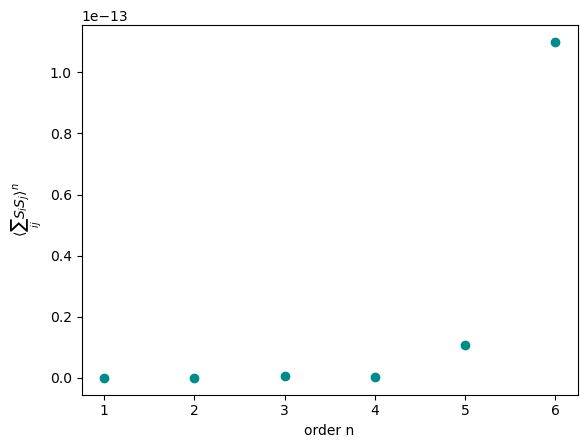

In [14]:
Vn1 = [Vn1_1, Vn1_2, Vn1_3, Vn1_4, Vn1_5, Vn1_6]#,Vn1_7]
print(Vn1)
order = [1,2,3,4,5,6]#,7]
plt.plot(order,np.abs(Vn1),color="darkcyan", marker='o',linestyle="")
plt.xlabel("order n")
plt.ylabel(r'$\langle \sum_{ij} S_i S_j \rangle^n$')